# Билет 3

In [ ]:
import random
import re
import typing as t
from collections import defaultdict
from pathlib import Path

import matplotlib.animation as animation
import matplotlib.pyplot as plt
import nltk
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from nltk.corpus import wordnet, stopwords
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

In [ ]:
# @formatter:off
%matplotlib inline
# @formatter:on

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [ ]:
torch.set_warn_always(True)

sns.set_theme()
plt.rcParams["figure.figsize"] = (8, 4)

In [ ]:
DATA_DIR = Path("../data/")

CUDA = "cuda"
CPU = "cpu"
DEVICE = CUDA if torch.cuda.is_available() else CPU
print(f"Using {DEVICE.upper()} device")

Using CPU device


## Предобработка данных и подготовка датасета

In [ ]:
def get_pos(word: str) -> str:
    tag = nltk.pos_tag([word])[0][1]
    if tag.startswith("J"):
        return wordnet.ADJ
    elif tag.startswith("V"):
        return wordnet.VERB
    elif tag.startswith("R"):
        return wordnet.ADV
    else:
        return wordnet.NOUN


_wordnet_lemmatizer = nltk.WordNetLemmatizer()


def wordnet_lemmatizer(token: str) -> str:
    return _wordnet_lemmatizer.lemmatize(token, pos=get_pos(token))


PATTERN = re.compile(r"[^a-z]", flags=re.MULTILINE)
STOPWORDS = set(stopwords.words("english"))


def preprocess_text(
        text: str,
        lemmatizer_or_stemmer: t.Callable[[str], str] = None,
        min_word_len: int = 0,
) -> str:
    text = text.lower()
    text = PATTERN.sub(" ", text)

    words = []
    for word in nltk.word_tokenize(text):
        if word not in STOPWORDS and len(word) >= min_word_len:
            if not lemmatizer_or_stemmer:
                words.append(word)
                continue
            word = lemmatizer_or_stemmer(word)
            if word not in STOPWORDS and len(word) >= min_word_len:
                words.append(word)

    return " ".join(words)

In [ ]:
class ActivitiesVocab:
    pad = "<PAD>"
    unknown = "<UNK>"

    def __init__(self, texts: t.List[str]):
        uniques = set()
        max_len = 0
        for text in texts:
            words = nltk.word_tokenize(text)
            uniques.update(words)
            max_len = max(len(words), max_len)

        self.alphabet = [self.pad, self.unknown, *uniques]
        self.max_len = max_len

        w2i = {w: i for i, w in enumerate(self.alphabet)}
        unknown_idx = w2i[self.unknown]
        self.w2i = defaultdict(lambda: unknown_idx, w2i)

    def __len__(self):
        return len(self.alphabet)

    def encode(self, text: str) -> torch.Tensor:
        indices = [self.w2i[w] for w in nltk.word_tokenize(text)]
        indices += [self.w2i[self.pad]] * (self.max_len - len(indices))
        return torch.tensor(indices, dtype=torch.long)

    def decode(self, indices: torch.Tensor) -> str:
        pad_indices = torch.nonzero(indices == self.w2i[self.pad], as_tuple=True)[0]  # noqa
        if len(pad_indices):
            indices = indices[:pad_indices[0]]
        return " ".join(self.alphabet[i] for i in indices)


class ActivitiesDataset(Dataset):
    df: pd.DataFrame
    texts: t.List[str]

    encoder: LabelEncoder
    classes: t.List[str]

    vocab: ActivitiesVocab
    data: torch.Tensor
    targets: torch.Tensor

    def __init__(self, df: pd.DataFrame, vocab: ActivitiesVocab = None, encoder: LabelEncoder = None):
        self.df = df

        with tqdm(total=len(df)) as pbar:
            self._pbar, self._i, self._n = pbar, 0, 100
            self.texts = df["text"].apply(self.preprocess_text).tolist()
        self.vocab = vocab or ActivitiesVocab(self.texts)

        if encoder:
            self.encoder = encoder
            encode = self.encoder.transform
        else:
            self.encoder = LabelEncoder()
            encode = self.encoder.fit_transform

        self.data = torch.vstack([self.vocab.encode(text) for text in self.texts])
        targets = encode(df["type"])
        self.classes = self.encoder.classes_.tolist()
        self.targets = torch.tensor(targets, dtype=torch.long)

    def __len__(self):
        return self.data.size(0)

    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

    def preprocess_text(self, text: str) -> str:
        self._i += 1
        if self._i % self._n == 0:
            self._pbar.update(self._n)
        return preprocess_text(text, lemmatizer_or_stemmer=wordnet_lemmatizer, min_word_len=3)

politics         345
medical          299
entertainment    260
sports           258
Name: type, dtype: int64


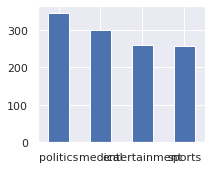

In [ ]:
activities_df = pd.read_csv("/content/tweet_cat.csv")
vc = activities_df["type"].value_counts()
print(vc)
activities_df["type"].value_counts().plot.bar(rot=0, figsize=(3, 2.5));

In [ ]:
train_df, test_df = train_test_split(activities_df, test_size=0.2, random_state=0)

train_dataset = ActivitiesDataset(train_df)
test_dataset = ActivitiesDataset(test_df, vocab=train_dataset.vocab, encoder=train_dataset.encoder)
len(train_dataset), len(test_dataset)

 86%|████████▌ | 200/233 [00:00<00:00, 444.00it/s]


(929, 233)

## Построение и обучение модели

In [ ]:
def get_weights(targets: torch.Tensor) -> torch.Tensor:
    _, counts = targets.unique(return_counts=True)
    return counts.max() / counts


def common_train(
        model: nn.Module,
        loss_fn: nn.Module,
        optimizer: optim.Optimizer,
        epochs: int,
        train_dataloader: DataLoader,
        test_dataloader: DataLoader,
        verbose: int = None,
        device: str = CPU,
) -> t.Tuple[t.List[float], t.List[float], t.List[float], t.List[float]]:
    train_losses, train_accuracy_list = [], []
    test_losses, test_accuracy_list = [], []
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}\n" + "-" * 32)

        train_loss, train_accuracy = train_loop(train_dataloader, model, loss_fn, optimizer, verbose, device)
        print(f"Train Error: loss: {train_loss:.6f}, accuracy: {train_accuracy:.4f}")
        train_losses.append(train_loss)
        train_accuracy_list.append(train_accuracy)

        test_loss, test_accuracy = test_loop(test_dataloader, model, loss_fn, device)
        print(f" Test Error: loss: {test_loss:.6f}, accuracy: {test_accuracy:.4f}\n")
        test_losses.append(test_loss)
        test_accuracy_list.append(test_accuracy)

        torch.cuda.empty_cache()
    return train_losses, train_accuracy_list, test_losses, test_accuracy_list


def train_loop(
        dataloader: DataLoader,
        model: nn.Module,
        loss_fn: nn.Module,
        optimizer: optim.Optimizer,
        verbose: int = None,
        device: str = CPU,
) -> t.Tuple[float, float]:
    model.train()

    size = len(dataloader.dataset)  # noqa
    num_batches = len(dataloader)
    avg_loss, avg_accuracy = 0, 0

    for batch, (x, y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)

        pred = model(x)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        y_true = torch.flatten(y).detach().cpu()
        y_pred = torch.flatten(pred.argmax(1)).detach().cpu()
        accuracy = metrics.accuracy_score(y_true, y_pred)

        avg_loss += loss
        avg_accuracy += accuracy
        if verbose and batch % verbose == 0:
            print(f"[{batch * len(x):>4d}/{size:>4d}]: loss: {loss:.6f}, accuracy: {accuracy:.4f}")

        del x, y, pred, loss
        torch.cuda.empty_cache()

    return (avg_loss / num_batches).item(), avg_accuracy / num_batches


@torch.no_grad()
def test_loop(
        dataloader: DataLoader,
        model: nn.Module,
        loss_fn: nn.Module,
        device: str = CPU,
) -> t.Tuple[float, float]:
    model.eval()
    y_true, y_pred = get_y_true_y_pred(model, dataloader, device)
    return loss_fn(y_pred, y_true).item(), metrics.accuracy_score(y_true.cpu(), y_pred.argmax(1).cpu())


@torch.no_grad()
def get_y_true_y_pred(
        model: nn.Module,
        dataloader: DataLoader,
        device: str = CPU,
) -> t.Tuple[torch.Tensor, torch.Tensor]:
    model.eval()

    y_test = []
    y_pred = []
    for x, y in dataloader:
        x, y = x.to(device), y.to(device)
        pred = model(x)
        y_test.append(y)
        y_pred.append(pred)

        del x
        torch.cuda.empty_cache()

    return torch.flatten(torch.vstack(y_test)), torch.vstack(y_pred)


def plot_train_test(
        train_losses: t.List[float],
        train_accuracy: t.List[float],
        test_losses: t.List[float],
        test_accuracy: t.List[float],
) -> None:
    fig, axes = plt.subplots(2, 1, figsize=(6, 7))
    epochs = torch.arange(len(train_losses))

    axes[0].plot(epochs, train_losses)
    axes[0].plot(epochs, test_losses)
    axes[0].set_ylabel("loss")
    axes[0].legend(["train", "test"])

    axes[1].plot(epochs, train_accuracy)
    axes[1].plot(epochs, test_accuracy)
    axes[1].set_xlabel("epoch")
    axes[1].set_ylabel("accuracy")

In [ ]:
class ActivitiesRNNClassifier(nn.Module):
    _STATE_T = t.Union[t.Optional[torch.Tensor], t.Optional[t.Tuple[torch.Tensor, torch.Tensor]]]
    rnn_state: _STATE_T

    def __init__(
            self,
            num_embeddings: int,
            embedding_dim: int,
            rnn_hidden_size: int,
            vector_size: int,
            num_classes: int,
    ):
        super().__init__()
        self.embedding = nn.Embedding(num_embeddings=num_embeddings, embedding_dim=embedding_dim, padding_idx=0)
        self.rnn = nn.RNN(input_size=embedding_dim, hidden_size=rnn_hidden_size, batch_first=True)
        self.classifier = nn.Sequential(
            nn.Linear(rnn_hidden_size * vector_size, 128),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(128, 5),
            nn.Linear(5, num_classes),
        )
        self.reset_rnn_state()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.embedding(x)

        x, rnn_state = self.rnn(x, self.rnn_state)
        self.keep_rnn_state(rnn_state)

        x = torch.flatten(x, 1)
        return self.classifier(x)

    def reset_rnn_state(self):
        self.rnn_state = None

    def keep_rnn_state(self, state: _STATE_T):
        if isinstance(self.rnn, nn.LSTM):
            self.rnn_state = (state[0].detach(), state[1].detach())
        else:
            self.rnn_state = state.detach()

    def train(self, mode: bool = True):
        self.reset_rnn_state()
        return super().train(mode)

In [ ]:
torch.manual_seed(0)

net = ActivitiesRNNClassifier(
    num_embeddings=len(train_dataset.vocab),
    embedding_dim=64,
    rnn_hidden_size=64,
    vector_size=train_dataset.vocab.max_len,
    num_classes=len(train_dataset.classes),
).to(DEVICE)
loss_fn = nn.CrossEntropyLoss(weight=get_weights(train_dataset.targets).to(DEVICE))
optimizer = optim.Adam(net.parameters(), lr=0.001)

train_dataloader = DataLoader(train_dataset, batch_size=33, shuffle=True, drop_last=False)
test_dataloader = DataLoader(test_dataset, batch_size=512, drop_last=False)

net

ActivitiesRNNClassifier(
  (embedding): Embedding(4996, 64, padding_idx=0)
  (rnn): RNN(64, 64, batch_first=True)
  (classifier): Sequential(
    (0): Linear(in_features=1152, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=128, out_features=5, bias=True)
    (4): Linear(in_features=5, out_features=4, bias=True)
  )
)

In [ ]:
%%time

train_losses, train_accuracy, test_losses, test_accuracy = common_train(
    epochs=10,
    model=net,
    loss_fn=loss_fn,
    optimizer=optimizer,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    verbose=50,
    device=DEVICE,
)

Epoch 1
--------------------------------
[   0/ 929]: loss: 1.364345, accuracy: 0.3939


RuntimeError: ignored

In [ ]:
plot_train_test(train_losses, train_accuracy, test_losses, test_accuracy)

In [ ]:
y_true, y_pred = get_y_true_y_pred(net, test_dataloader, DEVICE)
y_true, y_pred = y_true.cpu(), y_pred.argmax(1).cpu()

In [ ]:
cm_display = metrics.ConfusionMatrixDisplay.from_predictions(
    y_true,
    y_pred,
    display_labels=train_dataset.classes,
    colorbar=False,
    xticks_rotation=0,
    cmap=sns.color_palette('light:b', as_cmap=True)
)
cm_display.ax_.grid(False)
cm_display.figure_.set_size_inches(3.5, 3.5)

In [ ]:
print(metrics.classification_report(y_true, y_pred, target_names=train_dataset.classes, zero_division=True))

In [ ]:
net.eval()
for i in torch.randperm(len(test_dataset))[:5]:
    x, y = test_dataset[i]
    x, y = x.to(DEVICE), y.to(DEVICE)
    pred = net(x.unsqueeze(0))

    pred_proba, pred_label_indices = torch.softmax(pred, 1).topk(min(len(test_dataset.classes), 3), dim=1)
    pred_labels = test_dataset.encoder.inverse_transform(pred_label_indices.squeeze().cpu())
    predicts = ", ".join([f"{label} ({prob:.2f})" for (label, prob) in zip(pred_labels, pred_proba.squeeze())])

    text = test_dataset.texts[i]
    text = text if len(text) < 80 else text[:80] + "..."
    target = test_dataset.encoder.inverse_transform([y.cpu()])[0]

    print(f"Input:   {text}")
    print(f"Target:  {target}")
    print(f"Predict: {predicts}\n")

3 задача

In [ ]:
plt.rcParams["figure.figsize"] = (3.5, 2.5)

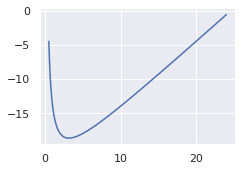

In [ ]:
def f(x: torch.Tensor) -> torch.Tensor:
    return (x**2-25*x+10)/x


SIGN = -1

START, END = 0.5, 24
EPS = 0.000001
LR = 0.001

X = torch.arange(START, END + 0.001, 0.001)
Y = f(X)
plt.plot(X.detach(), Y.detach());

In [ ]:
SignT = t.Literal[-1, 1] 
FuncT = t.Callable[[torch.Tensor], torch.Tensor]


def sign_func(func: FuncT, sign: SignT) -> FuncT:
    return lambda x: -sign * func(x)


def save_animation(xs: t.List[torch.Tensor], path: str, limit: int = 500, delay: int = 30) -> None:
    xs_ = xs.copy()
    delayed = xs_[-1]
    if len(xs_) > limit:
        xs_ = xs_[::len(xs_) // limit]
    for i in range(delay):
        xs_.append(delayed)

    with tqdm(total=len(xs_) + 1) as pbar:
        def animate(i):
            scatter.set_data(xs_[i].detach(), f(xs_[i]).detach())
            pbar.update()

        fig, ax = plt.subplots(1, 1)
        ax.plot(X.detach(), Y.detach())
        scatter, = ax.plot([], [], marker="o", color="r")
        anim = animation.FuncAnimation(fig, animate, interval=1, frames=len(xs_))
        anim.save(path, writer="pillow", fps=20)
        plt.close()


def answer(x: torch.Tensor, sign: SignT, reason: str) -> None:
    extrema = "минимум" if sign == -1 else "максимум"
    if torch.isnan(x):
        print(f"Локальный {extrema} не найден")
    else:
        x, y = x.item(), f(x).item()
        print(f"Найден локальный {extrema}: {x=:5f}, f(x)={y:5f}")
        plt.plot(X.detach(), Y.detach())
        plt.scatter(x, y, color="r")
    print(f"Причина остановки: {reason}")


def gradient_descent(
        func: FuncT,
        interval: t.Tuple[float, float],
        sign: SignT,
        eps: float,
        lr: float,
        initial_state: float = None,
) -> t.Tuple[torch.Tensor, t.List[torch.Tensor], str]:
    """Градиентный спуск"""
    sign_f = sign_func(func, sign)
    start, end = interval
    if initial_state is None:
        initial_state = random.uniform(start, end)
    elif initial_state < start or initial_state > end:
        return torch.tensor(torch.nan), [torch.tensor(torch.nan)], "initial_state вне интервала"

    interval_eps = lr * (end - start)  # наивное расширение границ интервала
    adj_start, adj_end = start - interval_eps, end + interval_eps

    x = torch.tensor(initial_state, dtype=torch.float, requires_grad=True)
    if torch.isnan(sign_f(x)):
        return torch.tensor(torch.nan), [torch.tensor(torch.nan)], f"f(initial_state={initial_state:.4f}) не определена"

    i, n = 0, 1000
    with tqdm() as pbar:
        xs = []
        while True:
            xs.append(x.detach().clone())  # выполнится минимум 2 раза

            if x < adj_start or x > adj_end:  # вышли за границу дальше дозволенного
                # искомый экстремум - предыдущая позиция или одна из границ
                start_t, end_t = torch.tensor(start), torch.tensor(end)
                if start <= xs[-2] <= end:
                    _, x = min((sign_f(xs[-2]), xs[-2]), (sign_f(start_t), start_t), (sign_f(end_t), end_t))
                else:
                    _, x = min((sign_f(start_t), start_t), (sign_f(end_t), end_t))
                xs.append(x.detach().clone())
                return xs[-1], xs, "выход за границы интервала"

            y = sign_f(x)
            if torch.isnan(y):
                xs.pop()
                return xs[-1], xs, f"функция для следующего x={x.item():.4f} не определена"

            # а эти 3 строчки про "возможности по автоматическому дифференцированию, которые предоставляет PyTorch"
            y.backward()
            grad = x.grad.clone()
            x.grad.zero_()

            with torch.no_grad():
                x -= lr * grad  # ладно, это 4-ая
                if torch.abs(x - xs[-1]) <= eps:  # найден экстремум с необходимой точностью
                    xs.append(x.detach().clone())
                    return xs[-1], xs, "найден экстремум"

            if i % n == 0:
                pbar.update(n)
            i += 1

18000it [00:03, 4867.19it/s]


Найден локальный минимум: x=3.163974, f(x)=-18.675446
Причина остановки: найден экстремум


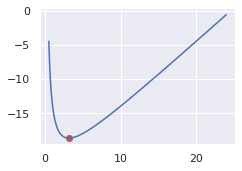

In [ ]:
x, xs, reason = gradient_descent(func=f, interval=(START, END), sign=SIGN, eps=EPS, lr=LR, initial_state=9.1)
answer(x, SIGN, reason)

In [ ]:
save_animation(xs, "autograd_1.gif")

100%|██████████| 540/540 [00:41<00:00, 13.12it/s]


![](autograd_1.gif)

In [ ]:
x, xs, reason = gradient_descent(func=f, interval=(START, END), sign=SIGN, eps=EPS, lr=LR, initial_state=-6)
answer(x, SIGN, reason)

Локальный минимум не найден
Причина остановки: initial_state вне интервала


In [ ]:
save_animation(xs, "autograd_2.gif")

100%|██████████| 32/32 [00:02<00:00, 10.88it/s]


![](autograd_2.gif)